In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
cd /Users/fred/Umila/numila

/Users/fred/Umila/numila


In [130]:
from sklearn import metrics
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('muted')

from main import run


# ROC

In [140]:
roc_df = pd.read_pickle('pickles/roc_holoprob')
roc_df['holo'] = [name.startswith('holo') for name in roc_df.model]
roc_df.head()

,auc,fpr,model,tpr,lang,kind,holo
0,0.666397,"[0.0, 0.0, 0.00196753566158, 0.00196753566158,...",holo,"[0.002, 0.02, 0.024, 0.026, 0.03, 0.038, 0.04,...",English,word,True
1,0.719731,"[0.0, 0.00393507132317, 0.00590260698475, 0.00...",prob,"[0.0, 0.008, 0.01, 0.014, 0.018, 0.036, 0.042,...",English,word,False
2,0.687880,"[0.0, 0.0, 0.00393507132317, 0.00590260698475,...",holo_flat,"[0.002, 0.02, 0.028, 0.032, 0.036, 0.038, 0.04...",English,word,True
3,0.723041,"[0.0, 0.00393507132317, 0.00590260698475, 0.00...",prob_flat,"[0.0, 0.008, 0.012, 0.016, 0.034, 0.036, 0.04,...",English,word,False
4,0.727433,"[0.0, 0.00393507132317, 0.00590260698475, 0.00...",holo_flat_full,"[0.002, 0.01, 0.014, 0.016, 0.02, 0.024, 0.028...",English,word,True


In [136]:
def roc_plot(df):
    ax = plt.subplot(1,1,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    for i, row in df.iterrows():
        plt.plot(row.fpr, row.tpr, label='{0} (area = {1:0.2f})'
                 .format(row.model, row['auc']))

    # Sort labels in legend.
    handles, labels = ax.get_legend_handles_labels()
    def get_aoc(handle_label):
        label = handle_label[1]
        return float(label[-5:-1])
    hl = sorted(zip(handles, labels), key=get_aoc, reverse=True)
    handles2, labels2 = zip(*hl)
    ax.legend(handles2, labels2, loc=4, frameon=True)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.gcf().set_size_inches(6, 6)

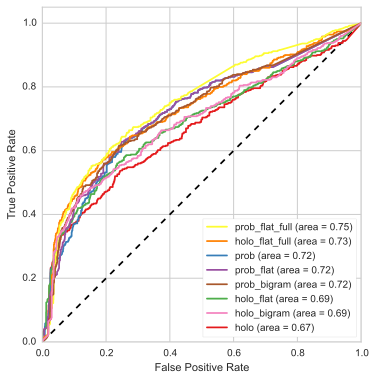

In [137]:
# Plot roc curve for English words.
with sns.color_palette('Set1', 10):
    roc_plot(roc_df.query("lang == 'English' and kind == 'word'"))
    # roc_plot(roc_df)
    plt.savefig('figs/roc-curve.pdf')

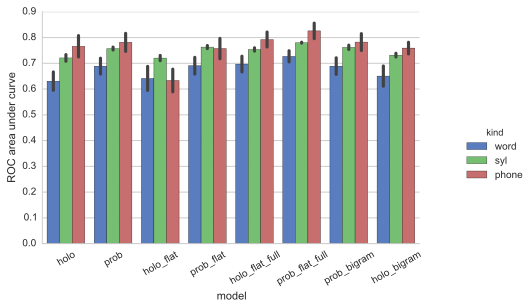

In [138]:
# ROC auc for each model and input type, collapsed across language
sns.factorplot('model', 'auc', hue='kind', kind='bar', data=roc_df)

plt.xticks(rotation=30)
plt.ylabel('ROC area under curve')
plt.gcf().set_size_inches(8, 4)
plt.savefig('figs/roc-type.pdf')

/Users/fred/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


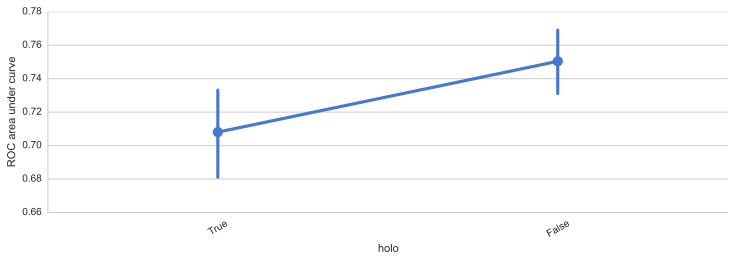

In [143]:
# ROC auc for each model and input type, collapsed across language
sns.factorplot('holo', 'auc', data=roc_df)
# sns.factorplot('model', 'auc', hue='lang', kind='bar', data=roc_df)

plt.xticks(rotation=30)
plt.ylabel('ROC area under curve')
plt.gcf().set_size_inches(12, 4)
plt.gcf().subplots_adjust(bottom=0.25)
plt.savefig('figs/roc-lang.pdf')
# plt.gcf().tight_layout()

In [69]:
roc_df.query("model=='holo_flat' and kind=='phone'")

[autoreload of main failed: Traceback (most recent call last):
  File "/Users/fred/anaconda/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/Users/fred/Umila/numila/main.py", line 213
    all_dfs = []
    ^
IndentationError: unexpected indent
]


,auc,fpr,model,tpr,lang,kind
3,0.684373,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",holo_flat,"[0.002, 0.012, 0.03, 0.038, 0.044, 0.058, 0.06...",English,phone
3,0.583407,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000514050719671, 0...",holo_flat,"[0.008, 0.014, 0.016, 0.028, 0.032, 0.032, 0.0...",Farsi,phone
3,0.608992,"[0.0, 0.00152284263959, 0.00152284263959, 0.00...",holo_flat,"[0.026, 0.042, 0.05, 0.054, 0.058, 0.066, 0.07...",Spanish,phone
3,0.651184,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",holo_flat,"[0.002, 0.004, 0.008, 0.01, 0.014, 0.026, 0.03...",German,phone
3,0.574171,"[0.0, 9.86290561199e-05, 9.86290561199e-05, 9....",holo_flat,"[0.0, 0.002, 0.006, 0.012, 0.014, 0.014, 0.02,...",Italian,phone
3,0.630839,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000214638334407, 0...",holo_flat,"[0.004, 0.034, 0.04, 0.048, 0.054, 0.054, 0.05...",Japanese,phone
3,0.608992,"[0.0, 0.00152284263959, 0.00152284263959, 0.00...",holo_flat,"[0.026, 0.042, 0.05, 0.054, 0.058, 0.066, 0.07...",Spanish,phone


# BLEU

In [39]:
bleu_df = pd.read_pickle('pickles/bleu')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

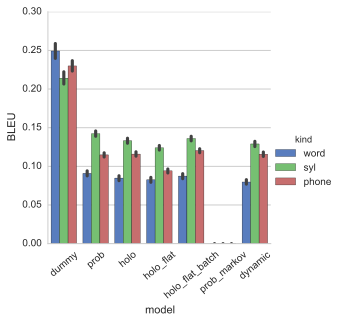

In [42]:
sns.factorplot(x='model', y='BLEU', hue='kind', data=bleu_df, kind='bar',
#             order=['holo', 'compose', 'prob',  'trigram']
               )
# plt.legend().draw_frame(True)
plt.savefig('figs/bleu.pdf')
plt.xticks(rotation=40)

In [ ]:
# full_df = roc_df[['ROC area under curve', 'model', 'language']].rename(columns={'ROC area under curve': 'measure'}).head()

full_df = pd.concat([pd.melt(roc_df, id_vars=['model', 'language'],
                   value_vars=['ROC area under curve'], var_name='measure'), 
           pd.melt(bleu_df, id_vars=['model', 'language'],
                   value_vars=['BLEU'], var_name='measure')])
    
sns.factorplot('model', 'value', hue='language', col='measure', data=full_df,
                   kind='bar', col_order=['BLEU', 'ROC area under curve'],
                   order=['holo', 'prob', 'trigram', 'random'])
plt.savefig('figs/combined.pdf')